In [124]:
# General
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import math


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


# Data Wrangling

In [2]:
#load and explore trip dataset
trip= pd.read_csv('trip.csv')

In [3]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [4]:
# check datatypes
trip.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [5]:
# check missing values
trip.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [6]:
# change start_date and end_date to datetime formate
trip['start_date']= pd.to_datetime(trip['start_date'],format='%m/%d/%Y %H:%M')
trip['end_date']= pd.to_datetime(trip['end_date'],format='%m/%d/%Y %H:%M')

In [7]:
# change duration from secondes to minutes
trip.duration = trip.duration/60

In [8]:
# check the duration outliers
trip.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

/Users/ruicao/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


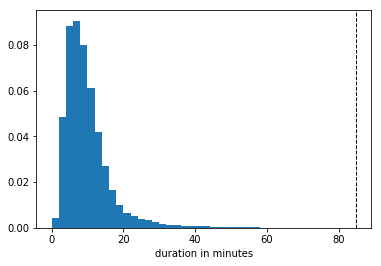

In [9]:
plt.hist(trip.duration,normed=True,bins=range(0,60,2))
plt.axvline(np.percentile(trip.duration,97.5), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('duration in minutes')
plt.show()

In [10]:
# remove outliers for trip duration more than 1 hour
trip = trip[trip.duration<=60]

In [11]:
# add some new columns for EDA 
trip['date']=trip['start_date'].dt.date
trip['day']=trip['start_date'].dt.dayofweek
trip['hour']=trip['start_date'].dt.hour
trip['month']=trip['start_date'].dt.month
trip['week']=trip['start_date'].dt.week

In [12]:
# rename columns day and month
trip.day= trip.day.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
trip.month = trip.month.map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})

In [13]:
# add holiday columns
cal = calendar()
holidays = cal.holidays(start = trip.date.min(),end=trip.date.max())
trip['holiday']= trip.date.apply(lambda x: x in(holidays))

In [14]:
# add workingday columns
workingday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
trip['workingday']=trip.day.isin(workingday)

In [15]:
# delte unuseful columns and change some columns datatype
trip.drop(['id','bike_id','zip_code'],axis=1,inplace=True)
for col in ['start_station_name','start_station_id','end_station_name','end_station_id','subscription_type','date','day','hour','week','month','week','holiday','workingday']:
    trip[col]=trip[col].astype('category')

In [16]:
# check the dataset after modify
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648717 entries, 0 to 669958
Data columns (total 15 columns):
duration              648717 non-null float64
start_date            648717 non-null datetime64[ns]
start_station_name    648717 non-null category
start_station_id      648717 non-null category
end_date              648717 non-null datetime64[ns]
end_station_name      648717 non-null category
end_station_id        648717 non-null category
subscription_type     648717 non-null category
date                  648717 non-null category
day                   648717 non-null category
hour                  648717 non-null category
month                 648717 non-null category
week                  648717 non-null category
holiday               648717 non-null category
workingday            648717 non-null category
dtypes: category(12), datetime64[ns](2), float64(1)
memory usage: 27.9 MB


In [156]:
trip.head()

,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,subscription_type,date,day,hour,month,week,holiday,workingday
0,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,Subscriber,2013-08-29,Thursday,14,August,35,False,True
1,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,14,August,35,False,True
2,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,Subscriber,2013-08-29,Thursday,10,August,35,False,True
3,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,11,August,35,False,True
4,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,Subscriber,2013-08-29,Thursday,12,August,35,False,True


In [17]:
# load and explore station file
station= pd.read_csv('station.csv')

In [18]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [19]:
# check datatypes
station.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [20]:
# check missing values
station.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [21]:
# change columns dtype
for col in ['name','city']:
    station[col]=station[col].astype('category')

In [22]:
# convert installation_date to datetime formate
station['installation_date']=pd.to_datetime(station.installation_date)

In [23]:
# load and explore weather file
weather = pd.read_csv('weather.csv')

In [24]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [25]:
#check datatypes
weather.dtypes

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches               object
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

In [26]:
# check missing values
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [27]:
# convert date column in datatime formate
weather['date'] = pd.to_datetime(weather.date)

In [28]:
# set date column as index, prepare for filling missing values
weather = weather.set_index('date', drop=True)

In [29]:
# check events column
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [30]:
# check which weather is more severe: Fog,Rain,Fog-Rain

In [31]:
weather[weather.events=='Fog'].mean_visibility_miles.mean()

7.357142857142857

In [32]:
weather[weather.events=='Fog'].mean_wind_speed_mph.mean()

3.9375

In [33]:
weather[weather.events=='Fog-Rain'].mean_visibility_miles.mean()

6.764705882352941

In [34]:
weather[weather.events=='Fog-Rain'].mean_wind_speed_mph.mean()

6.352941176470588

In [35]:
weather[weather.events=='Rain'].mean_visibility_miles.mean()

9.206185567010309

In [36]:
weather[weather.events=='Rain'].mean_wind_speed_mph.mean()

7.425257731958763

In [37]:
weather[weather.events=='Rain-Thunderstorm'].mean_visibility_miles.mean()

9.333333333333334

In [38]:
weather[weather.events=='Rain-Thunderstorm'].mean_wind_speed_mph.mean()

7.666666666666667

In [39]:
# write events properly and labeled them in numbers
weather.loc[weather.events == 'rain','events'] ='Rain'
weather.loc[weather.events.isnull(),'events'] ='Normal'
weather.events = weather.events.map({'Normal':0,'Rain':1,'Rain-Thunderstorm':1,'Fog':2,'Fog-Rain':3})

In [40]:
# convert traces of rain to .001 inches of rain to recognize that there was perciptation but it was a value less than what could be measured.
weather.loc[weather.precipitation_inches=='T','precipitation_inches']= 0.001

In [41]:
# convert objects columns to numeric values and fill na with its own average
weather = weather.convert_objects(convert_numeric=True)
weather = weather.fillna(weather.mean())

/Users/ruicao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [42]:
# check dataframe after modify
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3665 entries, 2013-08-29 to 2015-08-31
Data columns (total 23 columns):
max_temperature_f                 3665 non-null float64
mean_temperature_f                3665 non-null float64
min_temperature_f                 3665 non-null float64
max_dew_point_f                   3665 non-null float64
mean_dew_point_f                  3665 non-null float64
min_dew_point_f                   3665 non-null float64
max_humidity                      3665 non-null float64
mean_humidity                     3665 non-null float64
min_humidity                      3665 non-null float64
max_sea_level_pressure_inches     3665 non-null float64
mean_sea_level_pressure_inches    3665 non-null float64
min_sea_level_pressure_inches     3665 non-null float64
max_visibility_miles              3665 non-null float64
mean_visibility_miles             3665 non-null float64
min_visibility_miles              3665 non-null float64
max_wind_Speed_mph                3

In [43]:
weather.reset_index(inplace=True)

In [44]:
# check unique zip_code
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [45]:
# convert zip_code to city name
zipcode_city = dict({94107:'San Francisco',94063:'Redwood City',94301:'Palo Alto',94041:'Mountain View',95113:'San Jose'})
weather['city'] = weather.zip_code.apply(lambda x: zipcode_city[x])

In [46]:
# add a new column 'week'
weather['week']=weather.date.dt.week

In [47]:
# convert column datatype
for col in ['city','date']:
    weather[col] = weather[col].astype('category')

In [48]:
# drop unnecessary column
weather = weather.drop(['zip_code'],axis=1)

# Exploratory data analysis

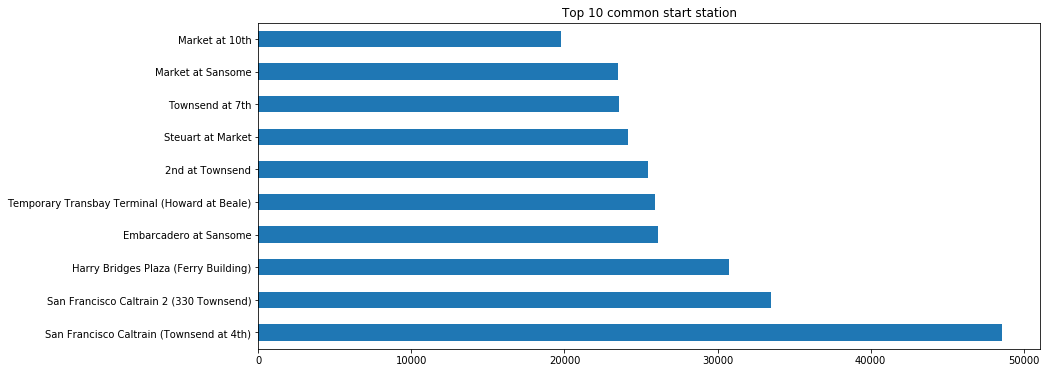

In [49]:
# top 10 common start station
trip['start_station_name'].value_counts().head(10).plot(kind='barh',figsize=(14,6))
plt.title('Top 10 common start station')
plt.show()

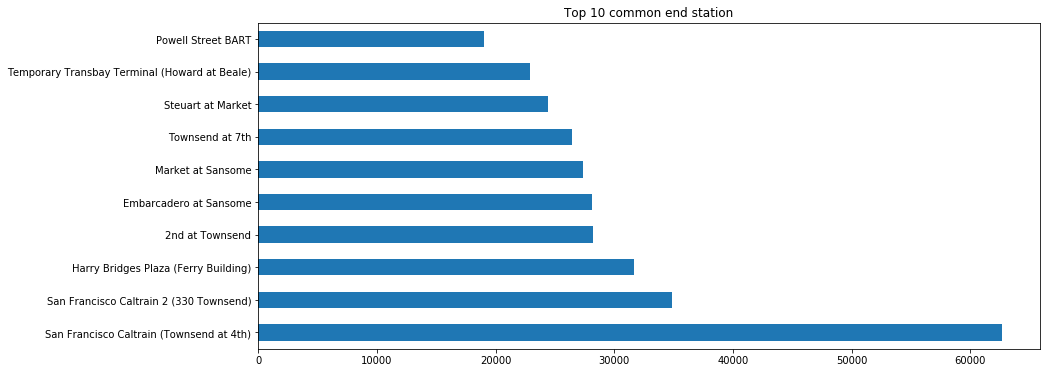

In [50]:
# top 10 common end station
trip['end_station_name'].value_counts().head(10).plot(kind='barh',figsize=(14,6))
plt.title('Top 10 common end station')
plt.show()

In [51]:
# anuual trip_counts by user type
total_count =trip.groupby(['date','subscription_type']).size().to_frame('count').reset_index()

In [52]:
total_count.head()

,date,subscription_type,count
0,2013-08-29,Customer,262
1,2013-08-29,Subscriber,456
2,2013-08-30,Customer,333
3,2013-08-30,Subscriber,305
4,2013-08-31,Customer,380


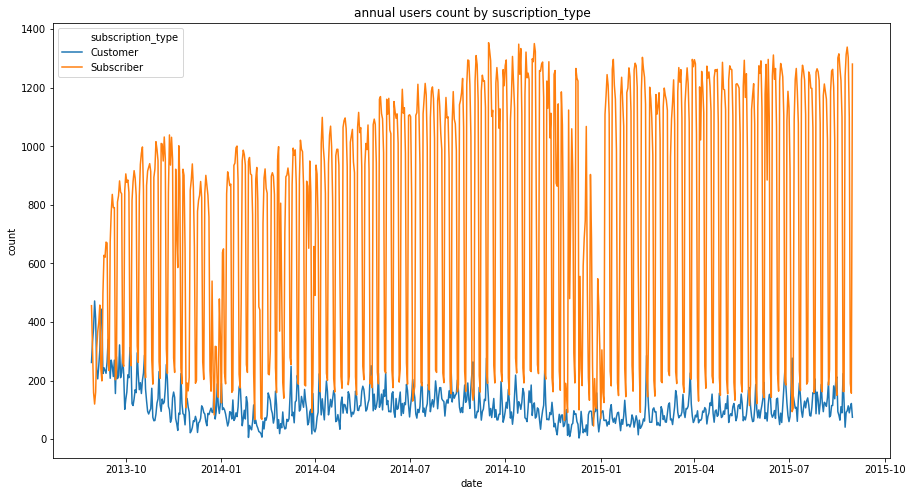

In [53]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date',y='count',hue ='subscription_type',data=total_count)
plt.title('annual users count by suscription_type')
plt.show()

In [54]:
# total uesrs count by workingdays
workingday = trip.groupby(['workingday','subscription_type']).size()
workingday = workingday.unstack('subscription_type')

In [55]:
workingday.head()

subscription_type,Customer,Subscriber
workingday,,
False,32392,41172
True,51235,523918


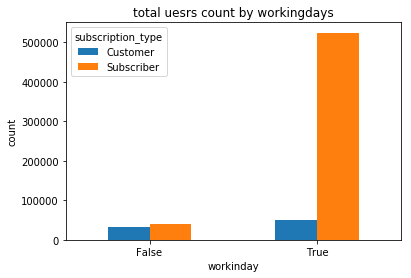

In [56]:
workingday.plot(kind='bar')
plt.xlabel('workinday')
plt.ylabel('count')
plt.xticks(rotation=360)
plt.title('total uesrs count by workingdays')
plt.show()

In [57]:
# total uesrs count by holidays
holiday = trip.groupby(['holiday','subscription_type']).size()
holiday = holiday.unstack('subscription_type')

In [58]:
holiday

subscription_type,Customer,Subscriber
holiday,,
False,80790,557889
True,2837,7201


In [59]:
# total counts by month

In [60]:
monthly_count = trip.groupby('month').size().to_frame('count').reset_index()

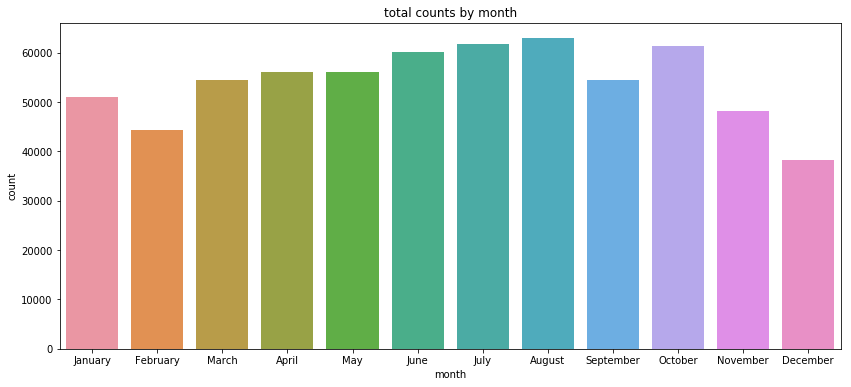

In [61]:
plt.figure(figsize=(14,6))
monthOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.barplot(data=monthly_count, x="month", y="count",order=monthOrder)
plt.title('total counts by month')
plt.show()

In [62]:
# total counts by hour of the day across weekdays

In [63]:
hourly_count = trip.groupby(['hour','day']).size().to_frame('count').reset_index()

In [64]:
hourly_count.head()

,hour,day,count
0,0,Friday,290
1,0,Monday,162
2,0,Saturday,451
3,0,Sunday,439
4,0,Thursday,266


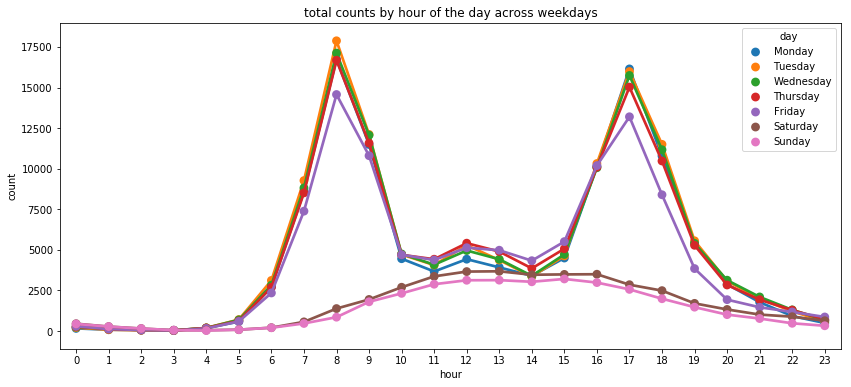

In [65]:
plt.figure(figsize=(14,6))
weekOrder =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.pointplot(x='hour',y='count',hue ='day',hue_order= weekOrder,data=hourly_count)
plt.title('total counts by hour of the day across weekdays')
plt.show()

In [66]:
# total counts by hour of the day across subscription_type

In [67]:
hourly = trip.groupby(['hour','subscription_type']).size().to_frame('count').reset_index()

In [68]:
hourly.head()

,hour,subscription_type,count
0,0,Customer,561
1,0,Subscriber,1498
2,1,Customer,398
3,1,Subscriber,679
4,2,Customer,244


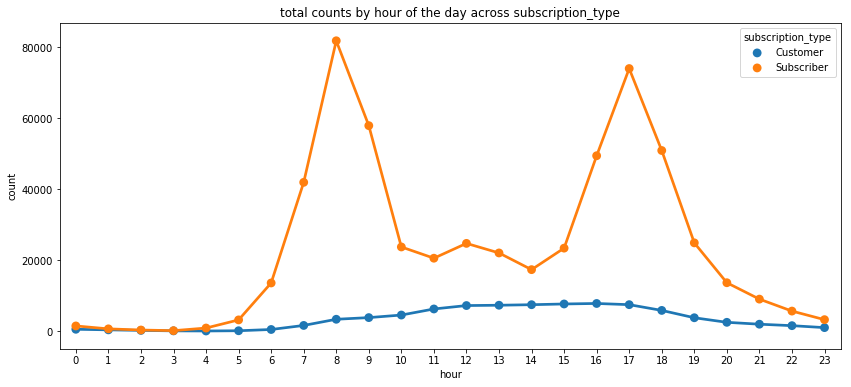

In [69]:
plt.figure(figsize=(14,6))
sns.pointplot(x='hour',y='count',hue ='subscription_type',data=hourly)
plt.title('total counts by hour of the day across subscription_type')
plt.show()

In [70]:
# merging trip dataframe with station and weather dataframe

In [71]:
# rename and drop columns
station.rename(columns = {'name':'station_name'},inplace=True)
station.drop(['id','lat','long','installation_date'],axis=1,inplace=True)

In [72]:
station.head()

,station_name,dock_count,city
0,San Jose Diridon Caltrain Station,27,San Jose
1,San Jose Civic Center,15,San Jose
2,Santa Clara at Almaden,11,San Jose
3,Adobe on Almaden,19,San Jose
4,San Pedro Square,15,San Jose


In [73]:
trip.head()

,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,subscription_type,date,day,hour,month,week,holiday,workingday
0,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,Subscriber,2013-08-29,Thursday,14,August,35,False,True
1,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,14,August,35,False,True
2,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,Subscriber,2013-08-29,Thursday,10,August,35,False,True
3,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,11,August,35,False,True
4,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,Subscriber,2013-08-29,Thursday,12,August,35,False,True


In [74]:
# create a DataFrame for machine learning 
df = trip.groupby(['date','start_station_name','holiday','workingday']).size().to_frame('trip_count').reset_index()
df.rename(columns={'start_station_name':'station_name'},inplace=True)

In [75]:
df.head()

,date,station_name,holiday,workingday,trip_count
0,2013-08-29,2nd at Folsom,False,True,12
1,2013-08-29,2nd at South Park,False,True,11
2,2013-08-29,2nd at Townsend,False,True,8
3,2013-08-29,5th at Howard,False,True,12
4,2013-08-29,Adobe on Almaden,False,True,3


In [76]:
# merge with station dataset
df = df.merge(station, how ='left',on='station_name')

In [77]:
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose


In [78]:
# check missing value
df.isnull().sum()

date               0
station_name       0
holiday            0
workingday         0
trip_count         0
dock_count      1150
city            1150
dtype: int64

In [79]:
# check the missing station name and which city it belongs
df[df.city.isnull()].station_name.value_counts()

Washington at Kearny          544
Post at Kearny                543
Broadway at Main               49
San Jose Government Center     14
Name: station_name, dtype: int64

In [80]:
df.dock_count.describe()

count    41514.000000
mean        18.091102
std          4.096896
min         11.000000
25%         15.000000
50%         19.000000
75%         19.000000
max         27.000000
Name: dock_count, dtype: float64

In [81]:
df[df.city=='San Francisco'].dock_count.describe()

count    24225.000000
mean        19.119051
std          3.737378
min         15.000000
25%         15.000000
50%         19.000000
75%         23.000000
max         27.000000
Name: dock_count, dtype: float64

In [82]:
df[df.city=='San Jose'].dock_count.describe()

count    9240.000000
mean       16.554113
std         3.679834
min        11.000000
25%        15.000000
50%        15.000000
75%        19.000000
max        27.000000
Name: dock_count, dtype: float64

In [83]:
df[df.city=='Redwood City'].dock_count.describe()

count    1716.000000
mean       18.193473
std         4.663597
min        15.000000
25%        15.000000
50%        15.000000
75%        25.000000
max        25.000000
Name: dock_count, dtype: float64

In [84]:
station_name_city = dict({'Washington at Kearny':'San Francisco','Post at Kearny':'San Francisco','Broadway at Main':'Redwood City','San Jose Government Center':'San Jose'})

In [85]:
# fiiling the city based on the station_name and filling dock count with overall dock mean value
df.city.fillna(df[df.city.isnull()].station_name.apply(lambda x:station_name_city[x]),inplace=True)
df.dock_count.fillna(df.dock_count.mean(),inplace=True)

In [86]:
#merge with weather

In [87]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,city,week
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,San Francisco,35
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,7.0,29.0,13.0,35.0,0.0,2.0,0,291.0,San Francisco,35
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,26.0,15.0,31.0,0.0,4.0,0,284.0,San Francisco,35
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,25.0,13.0,29.0,0.0,4.0,0,284.0,San Francisco,35
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,6.0,23.0,12.0,30.0,0.0,6.0,0,277.0,San Francisco,36


In [88]:
# check df dataframe
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose


In [89]:
# merge with weather
df = df.merge(weather,how='left',on=['date','city'] )

In [90]:
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,week
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose,81.0,72.0,63.0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,0,320.0,35


In [91]:
# check missing value
df.isnull().sum()

date                              0
station_name                      0
holiday                           0
workingday                        0
trip_count                        0
dock_count                        0
city                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
events                      

In [92]:
# check dtypes
df.dtypes

date                              category
station_name                        object
holiday                           category
workingday                        category
trip_count                           int64
dock_count                         float64
city                              category
max_temperature_f                  float64
mean_temperature_f                 float64
min_temperature_f                  float64
max_dew_point_f                    float64
mean_dew_point_f                   float64
min_dew_point_f                    float64
max_humidity                       float64
mean_humidity                      float64
min_humidity                       float64
max_sea_level_pressure_inches      float64
mean_sea_level_pressure_inches     float64
min_sea_level_pressure_inches      float64
max_visibility_miles               float64
mean_visibility_miles              float64
min_visibility_miles               float64
max_wind_Speed_mph                 float64
mean_wind_s

In [93]:
for col in ['station_name','events','week']:
    df[col] = df[col].astype('category')

In [94]:
# how events affects trip counts
events = df.groupby(['events','week']).trip_count.sum().to_frame('count').reset_index()
events.head(10)

,events,week,count
0,0,1,4571
1,0,2,10470
2,0,3,7804
3,0,4,10364
4,0,5,6062
5,0,6,5981
6,0,7,8398
7,0,8,10436
8,0,9,7219
9,0,10,7686


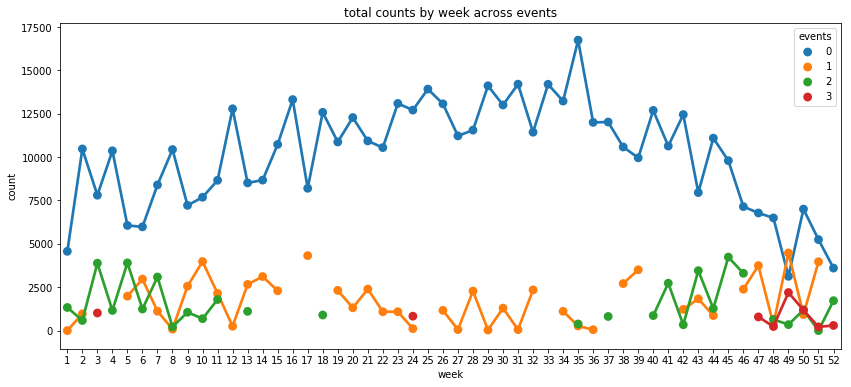

In [95]:
plt.figure(figsize=(14,6))
sns.pointplot(x='week',y='count',hue='events',data=events)
plt.title('total counts by week across events')
plt.show()

In [96]:
# how temperature affect trip counts
temperature_count = df.groupby(['mean_temperature_f','city','workingday']).size().to_frame('count').reset_index()
temperature_count.head()

,mean_temperature_f,city,workingday,count
0,38.0,Mountain View,False,4
1,38.0,Mountain View,True,15
2,38.0,San Jose,True,14
3,39.0,Palo Alto,False,2
4,39.0,San Jose,False,11


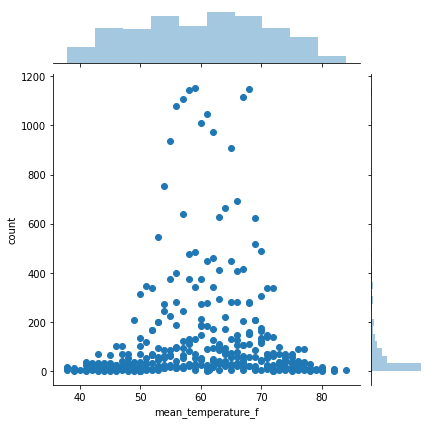

In [97]:
sns.jointplot('mean_temperature_f','count',data=temperature_count)

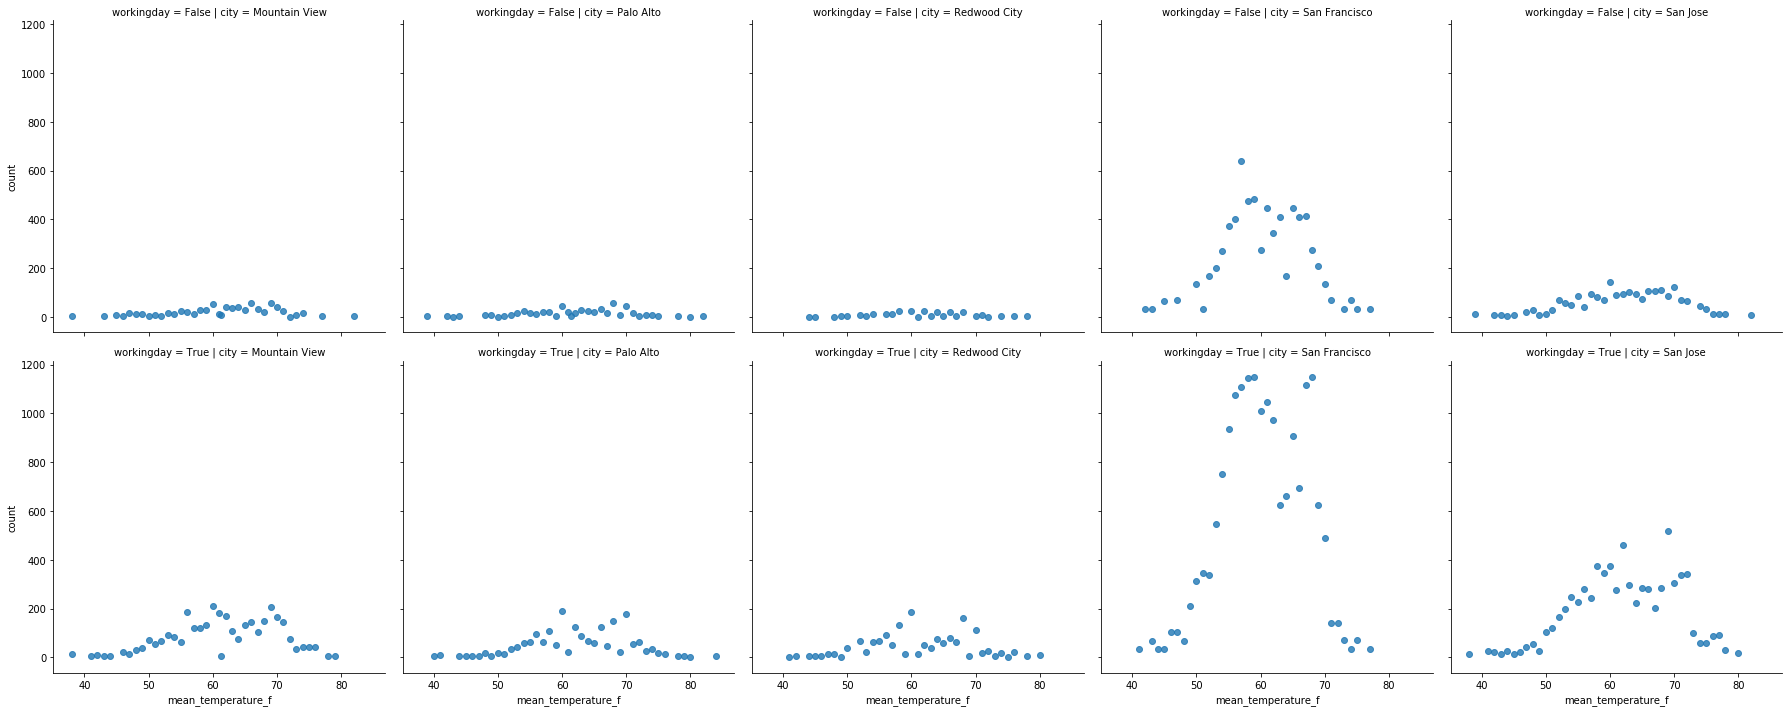

In [98]:
sns.lmplot('mean_temperature_f','count',row='workingday',col='city',data=temperature_count,fit_reg=False)

In [99]:
# how wind speed affect trip counts
wind_count = df.groupby(['mean_wind_speed_mph','city','workingday']).size().to_frame('count').reset_index()

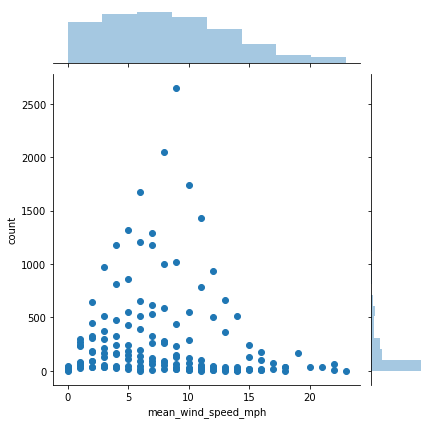

In [100]:
sns.jointplot('mean_wind_speed_mph','count',data=wind_count)

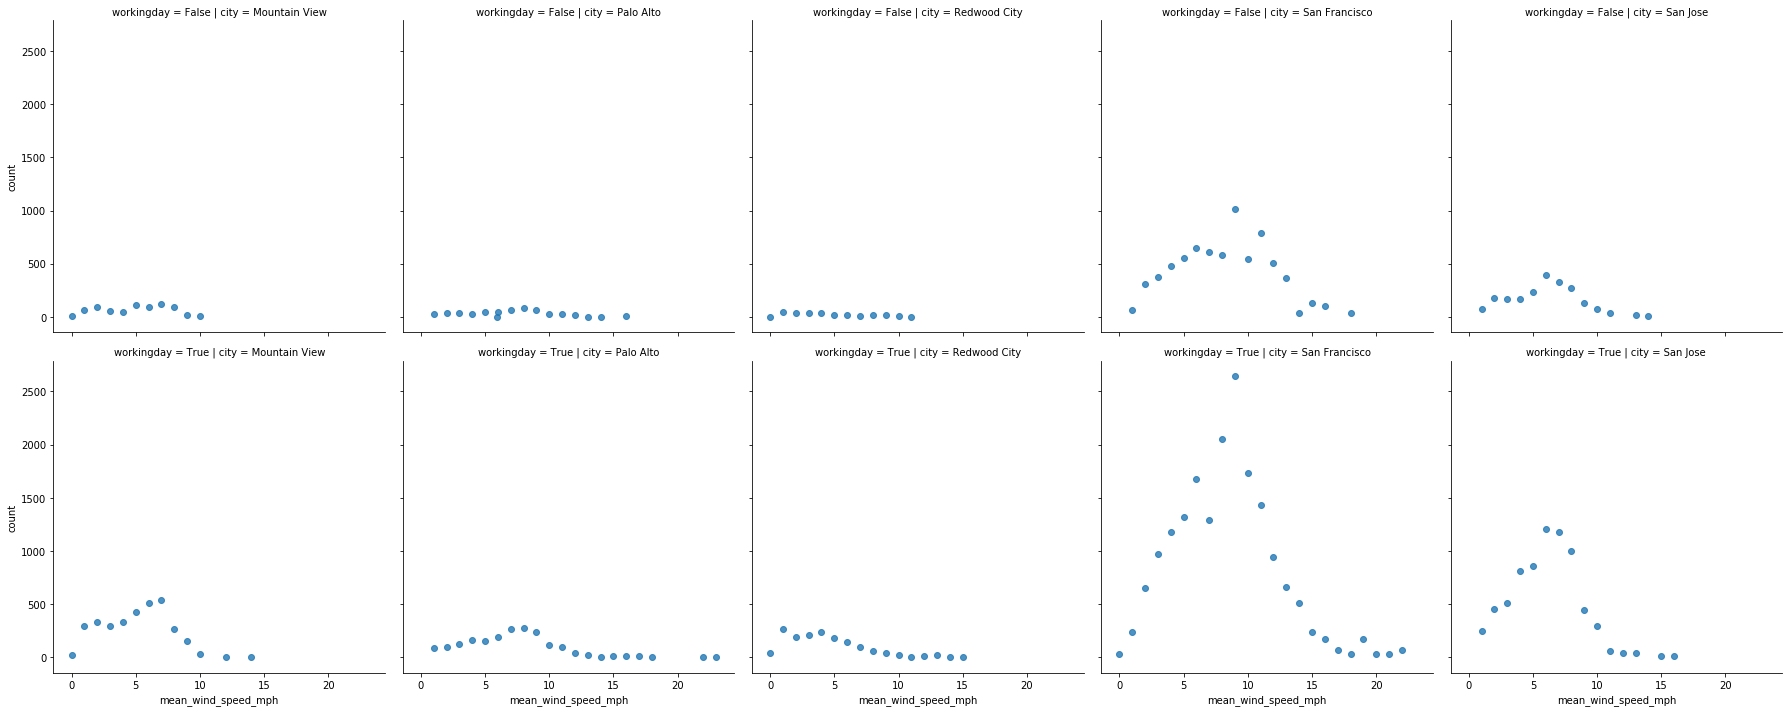

In [101]:
sns.lmplot('mean_wind_speed_mph','count',row='workingday',col='city',data=wind_count,fit_reg=False)

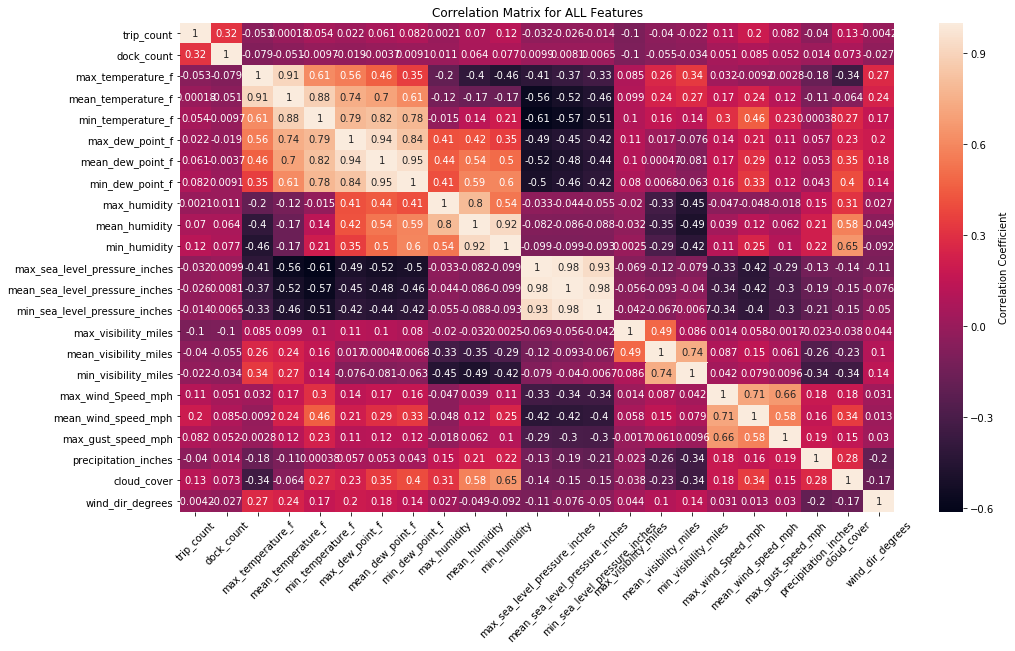

In [102]:
# overall heatmap
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True,cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix for ALL Features")
plt.xticks(rotation=45)
plt.show()

# Machine Learning

In [103]:
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,week
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose,81.0,72.0,63.0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,0,320.0,35


In [104]:
trip['start_station_name'].value_counts().head(10)

San Francisco Caltrain (Townsend at 4th)         48616
San Francisco Caltrain 2 (330 Townsend)          33488
Harry Bridges Plaza (Ferry Building)             30778
Embarcadero at Sansome                           26114
Temporary Transbay Terminal (Howard at Beale)    25884
2nd at Townsend                                  25427
Steuart at Market                                24180
Townsend at 7th                                  23571
Market at Sansome                                23524
Market at 10th                                   19777
Name: start_station_name, dtype: int64

In [105]:
df1 = df[df.station_name =='San Francisco Caltrain (Townsend at 4th)']

In [106]:
df1.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,week
41,2013-08-29,San Francisco Caltrain (Townsend at 4th),False,True,30,19.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
102,2013-08-30,San Francisco Caltrain (Townsend at 4th),False,True,25,19.0,San Francisco,78.0,69.0,60.0,...,10.0,7.0,29.0,13.0,35.0,0.0,2.0,0,291.0,35
160,2013-08-31,San Francisco Caltrain (Townsend at 4th),False,False,13,19.0,San Francisco,71.0,64.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0.0,4.0,0,284.0,35
214,2013-09-01,San Francisco Caltrain (Townsend at 4th),False,False,22,19.0,San Francisco,74.0,66.0,58.0,...,10.0,10.0,25.0,13.0,29.0,0.0,4.0,0,284.0,35
269,2013-09-02,San Francisco Caltrain (Townsend at 4th),True,True,20,19.0,San Francisco,75.0,69.0,62.0,...,10.0,6.0,23.0,12.0,30.0,0.0,6.0,0,277.0,36


In [107]:
#Convert True to 1 and False to 0
df1.workingday = df1.workingday.map(lambda x: 1 if x == True else 0)
df1.holiday = df1.holiday.map(lambda x: 1 if x == True else 0)

/Users/ruicao/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [108]:
#set test,train values
test = df1.trip_count
train=df1.drop(['date','trip_count','station_name','city'],axis=1)

In [109]:
# train_test split
X_train,X_test,y_train,y_test = train_test_split(train,test,test_size=0.33,random_state=42 )

In [110]:
# GridSearch
def Gridsearchcv(model,grid):
    model = GridSearchCV(model,grid,scoring='neg_mean_absolute_error',cv=5)
    model.fit(X_train,y_train)
    print('best parameter:{}'.format(model.best_params_),'best score:{}'.format(model.best_score_))

In [111]:
#Used mean absolute error to learn how many trips my predictions are off by.Multiply by -1 to make values positive.
def scoring(regressor):
    score = cross_val_score(regressor, X_train, y_train, cv=15, scoring = 'neg_mean_absolute_error')
    print ('neg_mean_absolute_error :{}'.format(np.mean(score) * -1))

Random Forest

In [112]:
rfr = RandomForestRegressor(random_state=42)
random_grid={'min_samples_leaf':[2,3,4],
            'n_estimators':[50,70,100]}

In [113]:
Gridsearchcv(rfr,random_grid)

best parameter:{'min_samples_leaf': 3, 'n_estimators': 50} best score:-11.948920499228663


In [114]:
rfr_1=RandomForestRegressor(n_estimators=50,min_samples_leaf=3,random_state=42)
scoring(rfr_1)

neg_mean_absolute_error :11.697565997996112


Decision Tree

In [115]:
dtr=DecisionTreeRegressor(random_state=42)
tree_grid={'min_samples_leaf':[2,3,4],
          'max_depth':[4,6,8]}

In [116]:
Gridsearchcv(dtr,tree_grid)

best parameter:{'max_depth': 6, 'min_samples_leaf': 4} best score:-13.181847011665253


In [118]:
dtr_1 = DecisionTreeRegressor(min_samples_leaf=4,max_depth=6,random_state=42)
scoring(dtr_1)

neg_mean_absolute_error :13.309726760472293


Linear Regression

In [126]:
lr = LinearRegression()

In [127]:
scoring(lr)

neg_mean_absolute_error :13.491414447927898


Gradient Boosting

In [131]:
gbr=GradientBoostingRegressor(random_state=42)
boost_grid={'learning_rate':[0.01,0.1,0.5],
           'n_estimators':[50,100,150],
           'max_depth':[2,4,6],
           'min_samples_leaf':[1,2,3]}

In [132]:
Gridsearchcv(gbr,boost_grid)

best parameter:{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 50} best score:-12.236257193193783


In [133]:
gbr_1=GradientBoostingRegressor(learning_rate=0.1,n_estimators=50,min_samples_leaf=3,max_depth=6,random_state=42)
scoring(gbr_1)

neg_mean_absolute_error :12.011138924583685


AdaBoost

In [136]:
abr=AdaBoostRegressor(random_state=42)
aboost_grid={'learning_rate':[0.01,0.1,0.5],
            'n_estimators':[50,100,150]}

In [137]:
Gridsearchcv(abr,aboost_grid)

best parameter:{'learning_rate': 0.01, 'n_estimators': 50} best score:-13.226909926146103


In [140]:
abr_1 =AdaBoostRegressor(learning_rate=0.01,n_estimators=50,random_state=42)
scoring(abr_1)

neg_mean_absolute_error :13.386809999239691


In [141]:
# predict the number of trips using the best model-random forest regressor
rfr_1.fit(X_train,y_train)
predicted=rfr_1.predict(X_test)

In [142]:
test.describe()

count    732.000000
mean      66.415301
std       40.367358
min        2.000000
25%       17.000000
50%       81.000000
75%       99.000000
max      143.000000
Name: trip_count, dtype: float64

In [151]:
y_test.reset_index(drop=True,inplace=True)

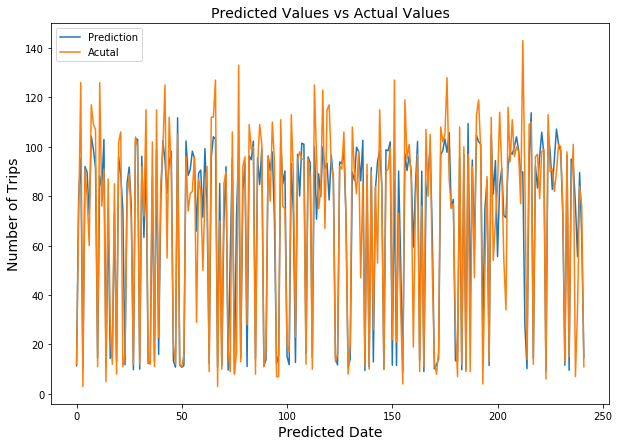

In [152]:
plt.figure(figsize=(10,7))
plt.plot(predicted)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = 14)
plt.xlabel("Predicted Date", fontsize = 14)
plt.title("Predicted Values vs Actual Values", fontsize = 14)
plt.show()

## Feature Importance

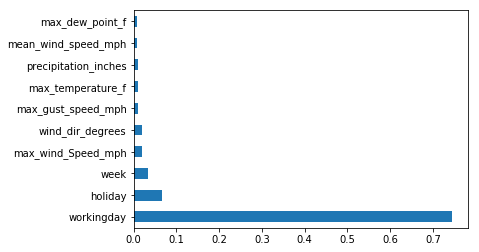

In [155]:
feature_importance = pd.Series(rfr_1.feature_importances_,index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()